# Лабораторная работа по курсу NLP. Классификация вопросов Stackoverflow
## Репин Владимир 382006-3м

## Загрузка и анализ данных

In [72]:
import pandas as pd
import sklearn
import numpy as np  
import seaborn as sns 
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook

sns.set_theme()
sns.set_style("whitegrid")
sns.set_palette("tab10")

In [73]:
data = pd.read_parquet('train.parquet') #https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate

Посмотрим на размер датасета и число признаков.

In [74]:
data.shape

(48000, 4)

Кажется, что нет большого смысла разделять текстовые признаки и обрабатывать их можно все вместе целиком. Особенно это касатеся заголовка + тела вопроса, но на самом деле отдельно обрабатывать теги и делать OHE тоже не удастся, потому что уникальных тегов около 7000, как можно будет увидеть ниже.

In [75]:
data['total'] = data['Title'] + data['Body'] + data['Tags']
data['length'] = data['Body'].str.len()
data['total'] = data['total'].str.lower()

Датасет идеально сбалансирован, данные по классам распределены поровну с точностью до единицы.

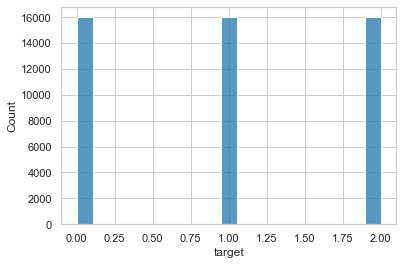

In [76]:
sns.histplot(x='target',data=data)
pass

Выше было добавлен признак "Длина вопроса", тут было интересно посмотреть как длина вопроса влияет на его статус. Определенно, более длинные запросы оцениваются положительно чаще.

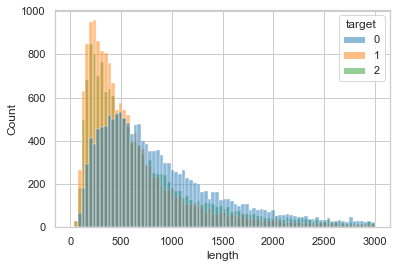

In [77]:
sns.histplot(x='length',hue='target',data=data, binrange=[0, 3000], palette='tab10')
pass

Просто небольшой sanity-check перед дальнейшей работой на предмет того, как выглядит датасет.

In [78]:
data.head()

,Body,Tags,Title,target,total,length
Id,,,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2,i am implementing a minimum spanning forrest a...,564
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2,"r studio: date is getting converted to number,...",109
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0,pandas - dataframe groupby - how to get sum of...,1365
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0,casting results from observable.forkjoin to th...,1721
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1,environment variable set in batch file cannot ...,165


## Classic Machine Learning

В разделе собраны только лучшие попытки применения ML, перепробовано было довольно много разных вещей, но в виде "наброска", без сохранения результатов.

In [79]:
data_train, data_val = train_test_split(data, test_size=0.05, random_state = 666, stratify = data['target'])

Одна из таких идей, которые пришли в самом конце - пунктуацию и разметки лучше не удалять, их наличие по идее сильно должно радовать отвечающих на вопрос. Поэтому используется токенизатор из nltk, который всё это сохраняет. Используется он в составе Bag-of-Words векторизатора.

In [80]:
bow_vectorizer = CountVectorizer(analyzer='word',tokenizer=nltk.word_tokenize)
train_vec = bow_vectorizer.fit_transform(data_train["total"])
val_vec = bow_vectorizer.transform(data_val["total"])

В общем и целом модель линейной регрессии даёт на этой задаче лучшие результаты, чем другие модели, причём с большим отрывом.
Сразу как данный факт был обнаружен, также было и замечено, что последний класс (заминусованные, но не закрытые вопросы) предсказывается почти идеально и пришла идея его отбросить и рассматривать задачу бинарной классификации.

In [81]:
clf = LogisticRegression(max_iter=500)
clf.fit(train_vec, data_train['target'])
y_pr = clf.predict(val_vec)
print(confusion_matrix(data_val['target'],y_pr,normalize='true'))
print(f1_score(data_val['target'],y_pr,average='macro'))

[[0.86625 0.13125 0.0025 ]
 [0.1025  0.88625 0.01125]
 [0.0025  0.0025  0.995  ]]
0.9156750137893969


D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Тут как раз это и происходит, создаётся новый подсет, который в дальнейшем везде будет использоваться, где класс с лейблом 2 выброшен из рассмотрения.

In [82]:
data_exp = data_train.drop(data_train[data_train['target'] == 2].index)
tfidf_vectorizer = TfidfVectorizer(analyzer='word',tokenizer=nltk.word_tokenize)
train_vec_exp = tfidf_vectorizer.fit_transform(data_exp["total"])
val_vec_exp = tfidf_vectorizer.transform(data_val["total"])

Тут как раз получилось так, что до токенизации с сохранением символов подход ниже давал существенное улучшение результата, используется ансамбль классификаторов, показавших приемлемые результаты. И уже намного позже оказалось, что сохранения пунктуации для простой линейной регрессии достаточно.

In [83]:
clf1 = LogisticRegression(max_iter = 300)
clf2 = PassiveAggressiveClassifier(C=0.01,max_iter=5000)
clf3 = AdaBoostClassifier(n_estimators=70)
clf_exp = VotingClassifier(estimators=[('lr', clf1),('pac',clf2),('ab',clf3)], voting='hard')
clf_exp = clf_exp.fit(train_vec_exp, data_exp['target'])




y_pr_exp = clf_exp.predict(val_vec_exp)
final = [i if i == 2 else j for i,j in zip(y_pr,y_pr_exp)]
print(confusion_matrix(data_val['target'],final,normalize='true'))
print(f1_score(data_val['target'],final,average='macro'))

[[0.8825  0.115   0.0025 ]
 [0.11875 0.87    0.01125]
 [0.0025  0.0025  0.995  ]]
0.915661981436394


Далее был попробован эмбеддинг Word2Vec также с классическим МЛ. Предобученная модель, очень удобно натренированная на сете stackoverflow.

In [13]:
w2v_model = KeyedVectors.load_word2vec_format('SO_vectors_200.bin', binary=True)

In [14]:
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
tokenizer = vectorizer.build_tokenizer()

In [15]:
data['raw_tokens'] = data['total'].apply(tokenizer)

In [16]:
def w2vectorizer(tokens):
    tmp = []
    for w in tokens:
        if w in w2v_model.key_to_index:
            tmp.append(w2v_model[w])
    return np.mean(tmp,axis=0)

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

И тогда как в векторизациях выше от различных слов текст я не очищал, то тут убрана и пунктуация и стоп-слова, получившийся набор токенов далее векторизуется взятием среднего от векторов всех слов. 

Использовался не только этот наивный подход. Изначально идея была такой: разбить текст на предложения, для каждого предложения брать взвешенное среднее по векторам слов, где весом выступал Inverse Document Frequency слова. Казалось, что так можно уменьшить влияние часто встречаемых слов и улучшить векторизацию. Число предложений, конечно, должно было стать одинаковым, поэтому брался 99 процентиль, это всего 16 предложений, а чего не хватало - заполнялось нулевыми векторами. К сожалению, этот подход дал результат крайне ниже ожидаемого (что-то вроде 0.6 fscore для линейной регрессии, которая уже тогда считалась собственным baseline). Времени было потрачено много, а код решено было убрать вовсе.

In [18]:
data['raw_tokens'].apply(lambda x: [item for item in x if item not in stop])

Id
34862324    [implementing, minimum, spanning, forrest, alg...
47303682    [studio, date, getting, converted, number, mak...
46431243    [pandas, dataframe, groupby, get, sum, multipl...
45306324    [casting, results, observable, forkjoin, respe...
49479547    [environment, variable, set, batch, file, cann...
                                  ...                        
35488105    [textbox, user, control, displaying, date, dd,...
37045803    [something, based, image, detection, making, p...
43601747    [kafkaproducer, difference, callback, returned...
40505904    [way, make, github, un, approve, pull, request...
40415937    [delete, two, array, objects, tableview, ios, ...
Name: raw_tokens, Length: 48000, dtype: object

In [19]:
data['vect'] = data['raw_tokens'].apply(w2vectorizer)

In [20]:
data_train_u, data_val_u = train_test_split(data, test_size=0.05, random_state = 666, stratify = data['target'])

In [21]:
data_train_ = np.stack(data_train_u['vect'].to_numpy())
data_val_ = np.stack(data_val_u['vect'].to_numpy())

In [22]:
clf1 = LogisticRegression(max_iter = 300)
clf2 = PassiveAggressiveClassifier(C=0.01,max_iter=5000)
clf3 = AdaBoostClassifier(n_estimators=70)
clf_exp_ = VotingClassifier(estimators=[('lr', clf1),('pac',clf2),('ab',clf3)], voting='hard')
clf_exp_ = clf_exp_.fit(data_train_, data_train_u['target'])

y_pr = clf_exp_.predict(data_val_)
print(confusion_matrix(data_val_u['target'],y_pr,normalize='true'))
print(f1_score(data_val_u['target'],y_pr,average='macro'))

D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[0.875   0.0875  0.0375 ]
 [0.23375 0.56125 0.205  ]
 [0.08875 0.11875 0.7925 ]]
0.7367690239315285


Как видно, наивный подход хоть и лучше озвученного выше, но всё равно плох. Скорее всего это связано с потерей кучи информации о качестве вопроса по разметке и пунктуации. Но в модели word2vec её не выразить.

## Neural Network

In [23]:
data_train_nn, data_val_nn = train_test_split(data_exp, test_size=0.05, random_state = 666, stratify = data_exp['target'])

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


Для нейросети сразу было решено натренировать свой эмбеддинг, это казалось более приемлемым, позволяло сохранить пунктуацию и локальные для данной модели вещи.

Датасет обрабатывается классом ниже, для представления в модель pytorch, это один из двух видов, второй - итератор. 

In [25]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015,tokenizer=nltk.word_tokenize)
        vectorizer.fit(df['total'].tolist())
        
        self.token2idx = vectorizer.vocabulary_
        
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df['total'].tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df['target'].tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [26]:
dataset = Sequences(data_train_nn, max_seq_len=300)

D:\Soft\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [51]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 200
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

Решено было попробовать простейшую рекуррентную нейронную сеть с архитектурой LSTM. Это не первое что было сделано, сначала была простая Fully Connected с 3 скрытыми слоями, как раз с подходом к векторизации по предложениям. Там тоже всё было ужасно и тоже не сохранено. Классификация по прежнему бинарная, учитывая достоверную классификацию другого класса.

In [52]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=300,
        hidden_size=300, 
        n_layers=1,
        device='cuda'
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(0.15)
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self ):
        
        return (torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device),
                torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device) )
       
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.dropout(output)
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [53]:
model = RNN(
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=batch_size
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(495, 300)
  (rnn): LSTM(300, 300, batch_first=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (decoder): Linear(in_features=300, out_features=1, bias=True)
)

In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.005)

In [55]:
model.train()
train_losses = []
for epoch in range(25):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

<ipython-input-55-57d28b47c4ff>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


Epoch #1	Train Loss: 0.455


Epoch #2	Train Loss: 0.302


Epoch #3	Train Loss: 0.266


Epoch #4	Train Loss: 0.241


Epoch #5	Train Loss: 0.217


Epoch #6	Train Loss: 0.193


Epoch #7	Train Loss: 0.174


Epoch #8	Train Loss: 0.162


Epoch #9	Train Loss: 0.158


Epoch #10	Train Loss: 0.156


Epoch #11	Train Loss: 0.137


Epoch #12	Train Loss: 0.128


Epoch #13	Train Loss: 0.110


Epoch #14	Train Loss: 0.111


Epoch #15	Train Loss: 0.113


Epoch #16	Train Loss: 0.112


Epoch #17	Train Loss: 0.109


Epoch #18	Train Loss: 0.104


Epoch #19	Train Loss: 0.093


Epoch #20	Train Loss: 0.082


Epoch #21	Train Loss: 0.090


Epoch #22	Train Loss: 0.086


Epoch #23	Train Loss: 0.079


Epoch #24	Train Loss: 0.084


Epoch #25	Train Loss: 0.093


In [56]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text)[:300])]).to(device)
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            return 1
        else:
            return 0

In [57]:
pr = []
for i, row in data_val_nn.iterrows():
    pr.append(predict_sentiment(row['total']))

In [58]:
print(confusion_matrix(data_val_nn['target'],pr,normalize='true'))

[[0.83026316 0.16973684]
 [0.13552632 0.86447368]]


Как видно, результат хоть и не очень плохой, но до baseline не дотянул. Используется то, что выдало лучший результат - classic ml.

## Ответ

In [61]:
test_data = pd.read_parquet('test.parquet')

In [62]:
test_data['total'] = test_data['Title'] + test_data['Body'] + test_data['Tags']

In [63]:
test_vec = bow_vectorizer.transform(test_data["total"])
test_vec_exp = tfidf_vectorizer.transform(test_data["total"])

In [66]:
pr2 = clf.predict(test_vec)
pr01 = clf_exp.predict(test_vec_exp)

In [67]:
res = []
for i,j in zip(pr2,pr01):
    if(i == 2):
        res.append(i)
    else:
        res.append(j)
answer = pd.DataFrame(data={'Id':test_data.index.tolist(), 'Predicted': res})

In [68]:
answer

,Id,Predicted
0,46785369,2
1,38908667,0
2,44703012,0
3,34910435,0
4,51632121,2
...,...,...
11995,37771316,0
11996,59044957,1
11997,57190511,0
11998,35228310,2


In [69]:
answer.to_csv("result.csv", index=False)

## Выводы

Разумеется, в данном случае нейросеть в теории должна была показывать лучшие результаты. Проблема, как мне кажется, в отсутствии опыта построения и поиска оптимальных параметров для обучения. Модели, которые я пытался использовать были довольно наивны и просты, скорее всего, более сложная модель, тем более для бинарной классификации, могла улучшить качество. Тем не менее, 0.91 fscore довольно прилично для классического ML, это при условии, что были сохранены критические вещи, влияющие на оценку вопроса. Не могу сказать, что будет с грамотной сетью при таких входных, но ML сильно просаживался в качестве при сохранении только слов.